In [1]:
import os
import sys
import json
import time
import pickle
import gspread
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.gridspec import GridSpec
from matplotlib.colorbar import Colorbar
from scipy import signal, fftpack
from datetime import date

In [2]:
sys.path.append(r'C:\Users\lesliec\code')

In [3]:
from tbd_eeg.tbd_eeg.data_analysis.eegutils import EEGexp
from tbd_eeg.tbd_eeg.data_analysis.Utilities.utilities import (
    get_stim_events,
    get_evoked_traces,
    get_evoked_firing_rates,
    find_nearest_ind
)
from allensdk.brain_observatory.ecephys.lfp_subsampling.subsampling import remove_lfp_offset
# from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache
from PCIst.PCIst.pci_st import calc_PCIst, dimensionality_reduction

In [4]:
%matplotlib notebook

Load CCF for identifying cortical areas

Load Zap_Zip-log_exp to get metadata for experiments

In [5]:
_gc = gspread.service_account() # need a key file to access the account
_sh = _gc.open('Zap_Zip-log_exp') # open the spreadsheet
_df = pd.DataFrame(_sh.sheet1.get()) # load the first worksheet
zzmetadata = _df.T.set_index(0).T # put it in a nicely formatted dataframe

Define areas of interest to plot population activity

In [6]:
areas_of_interest = {
    'MO': [
        'MOp1', 'MOp2/3', 'MOp5', 'MOp6a', 'MOp6b',
        'MOs1', 'MOs2/3', 'MOs5', 'MOs6a', 'MOs6b'
    ],
    'ACA': [
        'ACAd1', 'ACAd2/3', 'ACAd5', 'ACAd6a', 'ACAd6b',
        'ACAv1', 'ACAv2/3', 'ACAv5', 'ACAv6a', 'ACAv6b'
    ],
    'SS': [
        'SSp-bfd1', 'SSp-bfd2/3', 'SSp-bfd4', 'SSp-bfd5', 'SSp-bfd6a', 'SSp-bfd6b',
        'SSp-ll1', 'SSp-ll2/3', 'SSp-ll4', 'SSp-ll5', 'SSp-ll6a', 'SSp-ll6b',
        'SSp-tr1', 'SSp-tr2/3', 'SSp-tr4', 'SSp-tr5', 'SSp-tr6a', 'SSp-tr6b'
    ],
    'VIS': [
        'VISp1', 'VISp2/3', 'VISp4', 'VISp5', 'VISp6a', 'VISp6b',
        'VISam1', 'VISam2/3', 'VISam4', 'VISam5', 'VISam6a', 'VISam6b',
        'VISpm1', 'VISpm2/3', 'VISpm4', 'VISpm5', 'VISpm6a', 'VISpm6b',
        'VISrl1', 'VISrl2/3', 'VISrl4', 'VISrl5', 'VISrl6a', 'VISrl6b',
    ],
    'MO-TH': [
        'AV', 'CL', 'MD', 'PO', 'RT', 'VAL', 'VPL', 'VPM', 'VM'
    ],
}

In [7]:
area_colors = {
    'MO': 'blue', # [31, 157, 90]
    'ACA': 'deepskyblue', # [64, 166, 102]
    'SS': 'blueviolet', # [24, 128, 100]
    'VIS': 'green', # [8, 133, 140]
    'MO-TH': 'steelblue', # [255, 112, 128]
#     'VIS-TH': 'olivedrab'
}

In [8]:
state_colors = {
    'awake': (120/255, 156/255, 74/255),
    'anesthetized': (130/255, 122/255, 163/255),
    'recovery': (93/255, 167/255, 229/255)
}

#### Functions

In [9]:
def get_stim_event_inds(stim_table, stim_type, stim_param, sweep, trials='all'):
    if trials == 'resting':
        return stim_table[
            (stim_table['stim_type'] == stim_type) &
            (stim_table['parameter'] == stim_param) &
            (stim_table['sweep'] == sweep) &
            (stim_table['good'] == True) &
            (stim_table['resting_trial'] == True)
        ].index.values
    elif trials == 'running':
        return stim_table[
            (stim_table['stim_type'] == stim_type) &
            (stim_table['parameter'] == stim_param) &
            (stim_table['sweep'] == sweep) &
            (stim_table['good'] == True) &
            (stim_table['resting_trial'] == False)
        ].index.values
    else:
        return stim_table[
            (stim_table['stim_type'] == stim_type) &
            (stim_table['parameter'] == stim_param) &
            (stim_table['sweep'] == sweep) &
            (stim_table['good'] == True)
        ].index.values

In [10]:
def get_zFR(trig_FR, FRtime):
    
    trig_Z = np.zeros_like(trig_FR) * np.nan # try NaNs, it works
    baseline_avg = np.mean(trig_FR[FRtime < 0, :], axis=0)
    baseline_std = np.std(trig_FR[FRtime < 0, :], axis=0)
    nonzero_inds = np.nonzero(baseline_std)[0]
    trig_Z[:, nonzero_inds] = (trig_FR[:, nonzero_inds] - baseline_avg[None, nonzero_inds]) / baseline_std[None, nonzero_inds]
    
    return trig_Z

In [11]:
def get_normFR(trig_FR):
    
    norm_FR = np.zeros_like(trig_FR) # try zeros
    max_FR = np.max(trig_FR, axis=0)
    nonzero_inds = np.nonzero(max_FR)[0]
    norm_FR[:, nonzero_inds] = trig_FR[:, nonzero_inds] / max_FR[None, nonzero_inds]
    
    return norm_FR

In [12]:
def get_metadata(mdata_dict, metadf):
    exp_meta = metadf[(
        (metadf['mouse_name'].str.contains(mdata_dict['exp'].mouse)) &
        (metadf['exp_name'].str.contains(os.path.basename(os.path.dirname(mdata_dict['exp'].experiment_folder))))
    )].squeeze()
    
    ## Gets EEG_bad_chs, stim_currents, and PCI_stim ##
    try:
        EEG_bad_chs = mdata_dict['bad_chs']
    except KeyError:
        badchstr = exp_meta['EEG bad_channels'].replace(' ','')
        EEG_bad_chs = []
        for char in badchstr.split(','):
            if char.isdecimal():
                EEG_bad_chs.append(int(char))
    currentstr = exp_meta['Current (uA)'].replace(' ','')
    stim_currents = []
    for char in currentstr.split('/'):
        if char.isdecimal():
            stim_currents.append(char)
    if len(stim_currents) > 1:
        PCI_stim = stim_currents[1]
    elif len(currents_list) == 1:
        PCI_stim = stim_currents[0]
    else:
        print('No stim current listed in Zap_Zip-log_exp')
    return EEG_bad_chs, stim_currents, PCI_stim

## Load subjects from file

In [13]:
with open(r'C:\Users\lesliec\OneDrive - Allen Institute\data\all_iso_subjects_wPROBES.json') as subjects_file:
    multi_sub_dict = json.load(subjects_file)

In [14]:
plotsdir = r'C:\Users\lesliec\OneDrive - Allen Institute\data\plots\manuscript_figs'
# plotsdir = r'C:\Users\lesliec\OneDrive - Allen Institute\data\plots\GRC2022_poster'

## Choose example subjects and load experiment

In [15]:
example_mice = {
    'MOs_superficial': '571619',
    'MOs_deep': '571619'
}

In [16]:
ex_sub_dict = {x: {} for x in example_mice.keys()}
for group, mouse in example_mice.items():
    print('{} - {}'.format(group, mouse))
    ex_sub_dict[group][mouse] = multi_sub_dict[group][mouse]
    ex_sub_dict[group][mouse]['exp'] = EEGexp(multi_sub_dict[group][mouse]['data_loc'], preprocess=False, make_stim_csv=False)
    print('')

MOs_superficial - 571619
Experiment type: electrical stimulation

MOs_deep - 571619
Experiment type: electrical stimulation



## Gather data for example subjects

In [17]:
apply_car = True

ctx_regions = ['MO', 'ACA', 'SS', 'VIS']
time_bin = 0.0025 # size of time bins (s)
plot_cell_type = 'RS' # Can choose 'RS' or 'FS', only applies to the cortical regions, can't plot both together

current_levels = ['low', 'medium', 'high']
test_states = ['awake', 'anesthetized']

What metric to use if not z-score??

In [18]:
for group, group_subs in ex_sub_dict.items():
    print(group)
    for mouse_num, mdata in group_subs.items():
        print(' {}'.format(mouse_num))
        evoked_data_folder = os.path.join(mdata['exp'].data_folder, 'evoked_data')
        mdata['data'] = {}
        
        ## Load unit info ##
        fn_units_info = os.path.join(evoked_data_folder, 'all_units_info.csv')
        if os.path.exists(fn_units_info):
            unit_info = pd.read_csv(fn_units_info)
            with open(os.path.join(evoked_data_folder, 'units_event_spikes.pkl'), 'rb') as unit_file:
                all_unit_event_spikes = pickle.load(unit_file)
        else:
            print('  {} not found. Not analyzing this subject.'.format(fn_units_stats))
            continue
        
        ## Grab exp metadata from Zap_Zip-log_exp ##
        bad_chs, currents_list, PCI_stim_amp = get_metadata(mdata, zzmetadata)

        ## Load stim log (includes running speed now) ##
        stim_log = pd.read_csv(mdata['exp'].stimulus_log_file)
        stim_log = stim_log.astype({'parameter': str})
        event_window = all_unit_event_spikes['event_window']
        bins = np.arange(event_window[0], event_window[1] + time_bin, time_bin)
        timex = bins[:-1] + time_bin/2
            
        ## Load regional stuff ##
        reg_unit_info = {}
        for region in areas_of_interest.keys():
            if region in ctx_regions:
                regdf = unit_info[(unit_info['cell_type'] == plot_cell_type) & (unit_info['parent'] == region)]
            else:
                regdf = unit_info[unit_info['parent'] == region]
            if len(regdf) > 5:
                reg_unit_info[region] = regdf.sort_values(by='depth').reset_index(drop=True)
        
        ## Get event inds ##
        all_event_inds = {}
        for leveli, parami in zip(current_levels, currents_list):
            all_event_inds[leveli] = {}
            for statei in ['awake', 'anesthetized']:
                sweeps = mdata['states'][statei]
                if not sweeps:
                    continue
                state_events = []
                for sweepi in sweeps:
                    events = get_stim_event_inds(stim_log, 'biphasic', parami, sweepi, trials='all')
                    if len(events) == 0:
                        continue
                    state_events.append(events)
                all_event_inds[leveli][statei] = np.concatenate(state_events)
                if statei == 'awake':
                    substates = ['resting', 'running']
                    for substatei in substates:
                        state_events = []
                        for sweepi in sweeps:
                            events = get_stim_event_inds(stim_log, 'biphasic', parami, sweepi, trials=substatei)
                            if len(events) == 0:
                                continue
                            state_events.append(events)
                        all_event_inds[leveli][substatei] = np.concatenate(state_events)
        
        normFR = {}
        zscoreFR = {}
        for leveli, states_event_times in all_event_inds.items():
            normFR[leveli] = {}
            zscoreFR[leveli] = {}
            for statei in test_states:
                event_inds = states_event_times[statei]
                normFR[leveli][statei] = {}
                zscoreFR[leveli][statei] = {}

                for region in areas_of_interest.keys():
                    ## Get unit normalized firing rate ##
                    if region in reg_unit_info.keys():
                        unit_firing_rates = np.zeros((len(timex), len(reg_unit_info[region])), dtype=float) * np.nan
                        for ii, unitrow in reg_unit_info[region].iterrows():
                            unit_event_spikes = [
                                all_unit_event_spikes['event_spikes'][unitrow.unit_id][ei] for ei in event_inds]
                            unit_event_counts, edges = np.histogram(np.concatenate(unit_event_spikes), bins)
                            unit_firing_rates[:, ii] = unit_event_counts / (time_bin * len(event_inds))
                        normFR[leveli][statei][region] = [timex, get_normFR(unit_firing_rates)]
                        zscoreFR[leveli][statei][region] = [timex, get_zFR(unit_firing_rates, timex)]
        
        mdata['data']['unit_normFR'] = normFR
        mdata['data']['unit_zscoreFR'] = zscoreFR
        
        ### After each subject, delete common variables ###
        del stim_log, unit_info, all_unit_event_spikes, reg_unit_info, normFR, zscoreFR
    print('')

MOs_superficial
 571619

MOs_deep
 571619



### Plot figure 2ish: comparing zscore to normalized firing rate, awake deep stim only

<IPython.core.display.Javascript object>


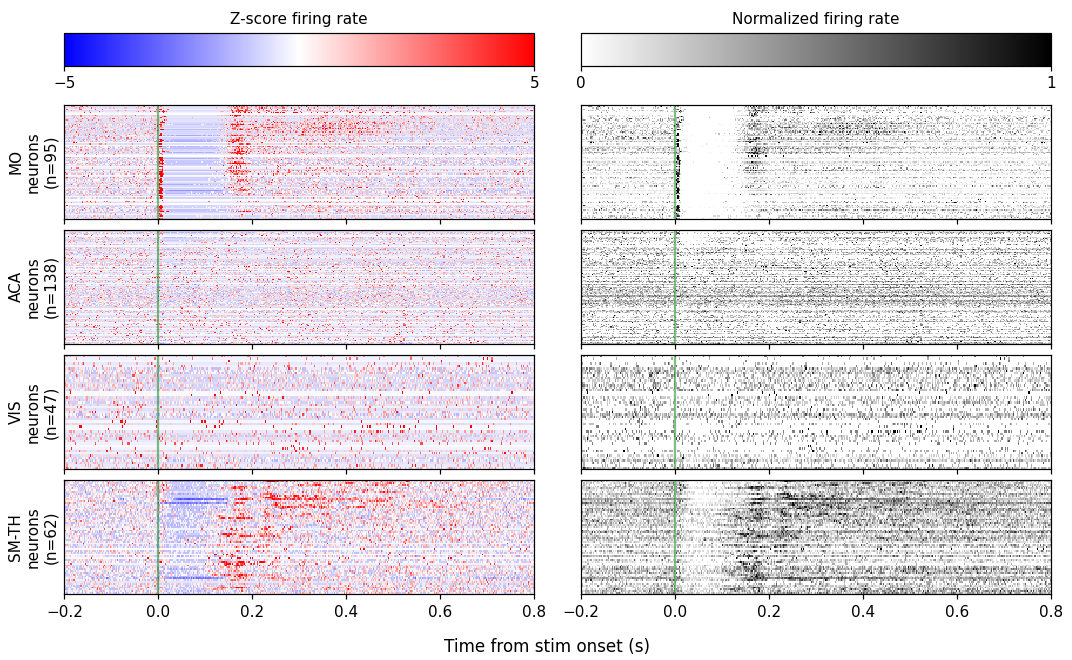

In [34]:
plwin = [-0.2, 0.8]
pgroup = 'MOs_deep'
pmouse = '571619'
plevel = 'medium'
pstate = 'awake'
plotregions = ['MO', 'ACA', 'VIS', 'MO-TH']
plotvals = {'unit_zscoreFR': [[-5, 5], 'bwr'], 'unit_normFR': [[0, 1], 'binary']}
cblabels = ['Z-score firing rate', 'Normalized firing rate']

fig = plt.figure(figsize=(9.75, 6))
gs = fig.add_gridspec(
    ncols=len(plotvals), nrows=2, height_ratios=[1, 15], left=0.06, right=0.98, top=0.95, bottom=0.1,
    wspace=0.1, hspace=0.15)
# EEGaxs = gs[0,0].subgridspec(ncols=len(example_mice), nrows=1, wspace=0.05).subplots(sharex=True, sharey=True)
# NPXgs = gs[1,0].subgridspec(ncols=len(example_mice), nrows=len(plotregions), hspace=0.1, wspace=0.05)

for ii, (pdata, pinfo) in enumerate(plotvals.items()):
    plottraces = ex_sub_dict[pgroup][pmouse]['data'][pdata][plevel][pstate]
    axs = gs[1,ii].subgridspec(ncols=1, nrows=len(plotregions), hspace=0.1, wspace=0.05).subplots(sharex=True)
    
    for ax, region in zip(axs, plotregions):
        if region == 'MO-TH':
            reglabel = 'SM-TH'
        else:
            reglabel = region
        ## plot FRs ##
        imunit = ax.imshow(
            plottraces[region][1].T, cmap=pinfo[1], aspect='auto', origin='upper',
            vmin=pinfo[0][0], vmax=pinfo[0][1], interpolation='none',
            extent=[plottraces[region][0][0], plottraces[region][0][-1], 0, plottraces[region][1].shape[0]],
        )
        
        ax.set_xlim(plwin)
        ax.axvline(0, color='g', alpha=0.5)
        ax.set_yticks([])
        if ii == 0:
            ax.set_ylabel('{}\nneurons\n(n={:d})'.format(reglabel, plottraces[region][1].shape[1]), fontsize=10)
            
    ## Add the colorbar ##
    lcbax = fig.add_subplot(gs[0,ii])
    lcb = Colorbar(ax=lcbax, mappable=imunit, orientation='horizontal', ticklocation='bottom')
    lcb.set_ticks(pinfo[0])
    lcbax.set_title(cblabels[ii])
    
fig.text(0.51, 0.02, 'Time from stim onset (s)', va='center', ha='center', fontsize=11)

## Save ##
figname = 'FR_zscorevnorm_{}_{}_{}.png'.format(plot_cell_type, statei, date.today().strftime('%b%d%Y'))
# fig.savefig(os.path.join(plotsdir, figname), transparent=False, dpi=300)

# Original from figure 2